In [11]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
# mat_contents = sio.loadmat('EEG_data_KOS_1+2.mat') # or ('EEG_data.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big4CNN.mat')
mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->0.5-38Hz,Env=1.mat')


X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=False)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and minmax normalize:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
    y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
    y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
    y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
    y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test,3)
y_test = np.expand_dims(y_test,1)
y_test = y_test[:,:,:,None]
y_train = np.expand_dims(y_train,1)
y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')

leng = X.shape[2]
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (69, 60, 800, 1) Nomralized MEAN: 0.5083 min 0.0 max 1.0
train input shape (272, 60, 800, 1) Nomralized MEAN: 0.51123 min 0.0 max 1.0
test labels shape (69, 1, 800, 1) Nomralized MEAN: 0.31958 min 0.0 max 1.0
train labels shape (272, 1, 800, 1) Nomralized MEAN: 0.28003 min 0.0 max 1.0


In [12]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

# we first define the autoencoder's architecture:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.models import Model
from keras import optimizers
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard, Callback
import numpy as np
import matplotlib.pyplot as plt

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

def Encoder():
    input_img = Input(shape=(60, leng, 1))  # adapt this if using `channels_first` image data format  
    
    e1 = Conv2D(8, (5, 5), activation='relu', padding='same')(input_img)
    e1b = BatchNormalization(axis=1)(e1)
    e1a = Dropout(0.1)(e1b)
    e2 = MaxPooling2D((2, 2), padding='same')(e1a)
    
    e3 = Conv2D(16, (4, 4), activation='relu', padding='same')(e2)
    e3b = BatchNormalization(axis=1)(e3)
    e3a = Dropout(0.1)(e3b)
    e4 = MaxPooling2D((3, 2), padding='same')(e3a)
    
    e5 = Conv2D(32, (2, 2), activation='relu', padding='same')(e4)
    e5b = BatchNormalization(axis=1)(e5)
    e5a = Dropout(0.2)(e5b)
    e6 = MaxPooling2D((2, 2), padding='same')(e5a)
    
    return Model(input_img, e6)

def Decoder():
    input_img = Input(shape=(5, 100, 32))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    d1b = BatchNormalization(axis=1)(d1)
    d1a = Dropout(0.2)(d1b)
    d2 = UpSampling2D((2, 2))(d1a)
    d3 = Conv2D(16, (3, 3), activation='relu', padding='same')(d2)
    d3b = BatchNormalization(axis=1)(d3)
    d3a = Dropout(0.3)(d3b)
    d4 = UpSampling2D((3, 2))(d3a)
    d5 = Conv2D(8, (3, 3), activation='relu', padding='same')(d4)
    d5b = BatchNormalization(axis=1)(d5)
    d5a = Dropout(0.4)(d5b)
    d6 = UpSampling2D((2, 2))(d5a)
    d7 = Conv2D(1, (3, 3), activation='relu', padding='same')(d6)
    return Model(input_img, d7)

In [13]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

In [14]:
# define input to the model:
x = Input(shape=(60, leng, 1))

# make the encoder:
enc = Model(x, Encoder()(x))
# enc.compile(optimizer='adadelta', loss='binary_crossentropy')

# make the model:
autoencoder = Model(x, Decoder()(enc(x)))

# compile the model:
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# autoencoder.compile(optimizer=sgd, loss=correlation_coefficient_loss)
autoencoder.compile(optimizer='adadelta', loss=correlation_coefficient_loss)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [15]:
# SEE INSIDE THE ENCODER AND DECODER:
Encoder().summary()
Decoder().summary()

# IN FACT, OUR AUTOENCODER WILL BE A CONCATENATION OF TWO MODELS
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 60, 800, 1)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 800, 8)        208       
_________________________________________________________________
batch_normalization_19 (Batc (None, 60, 800, 8)        240       
_________________________________________________________________
dropout_19 (Dropout)         (None, 60, 800, 8)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 400, 8)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 400, 16)       2064      
_________________________________________________________________
batch_normalization_20 (Batc (None, 30, 400, 16)       120       
__________

Text(0.5,1,'Channels 11 in test samples 6 and 16')

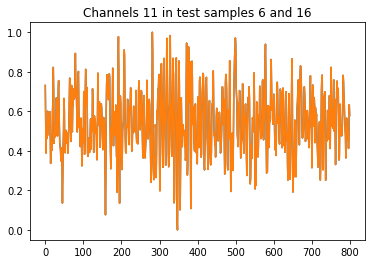

In [16]:
# inspect channel 11
%matplotlib inline
plt.plot(range(0, leng), x_test[15,10,:,0], range(0, leng), x_test[15,10,:,0])
ax = plt.gca()
ax.set_title("Channels 11 in test samples 6 and 16")

In [27]:
# Training time!

train_history = autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test),
#                 callbacks=[TensorBoard(log_dir='/home/amplifier/home/NEW_DL/logs/EEG_CNN_autoencoder'), 
#                           history]
                               )

# save the entire model and the weights after the training:
autoencoder.save('/home/amplifier/home/NEW_DL/models/CNN_autoencoder.h5')
autoencoder.save_weights('/home/amplifier/home/NEW_DL/weights/CNN_autoencoder_weights.h5')
enc.save('/home/amplifier/home/NEW_DL/models/CNN_encoder_model.h5')

Train on 272 samples, validate on 69 samples
Epoch 1/5
272/272 [==============================] - 1s 3ms/step - loss: 0.7979 - val_loss: 0.7346
Epoch 2/5
272/272 [==============================] - 1s 3ms/step - loss: 0.7977 - val_loss: 0.7241
Epoch 3/5
272/272 [==============================] - 1s 3ms/step - loss: 0.7983 - val_loss: 0.7469
Epoch 4/5
272/272 [==============================] - 1s 3ms/step - loss: 0.7984 - val_loss: 0.7200
Epoch 5/5
272/272 [==============================] - 1s 3ms/step - loss: 0.7982 - val_loss: 0.7405


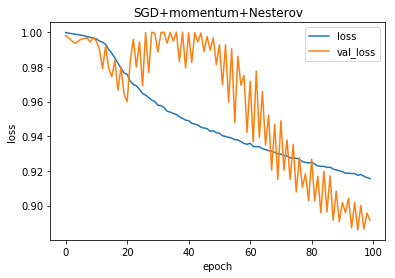

In [20]:
# print(np.array(history.losses))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('SGD+momentum+Nesterov')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

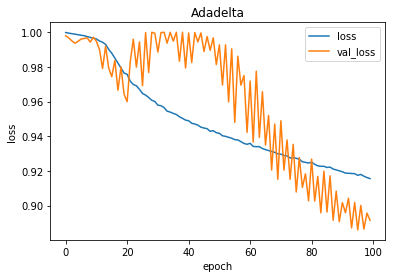

In [21]:
# print(np.array(history.losses))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('Adadelta')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [22]:
# let's predict a TRAINING sammple:
decoded_train = autoencoder.predict(x_train)
decoded_test = autoencoder.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(272, 60, 800, 1)
(69, 60, 800, 1)


Training sample 0 : Correlation  [-0.70163512]  P-value:  [ 0.]
Training sample 1 : Correlation  [-0.69630641]  P-value:  [ 0.]
Training sample 2 : Correlation  [-0.70659703]  P-value:  [ 0.]
Training sample 3 : Correlation  [-0.64267588]  P-value:  [ 0.]
Training sample 4 : Correlation  [-0.57833505]  P-value:  [ 0.]
Training sample 5 : Correlation  [-0.57897043]  P-value:  [ 0.]
Training sample 6 : Correlation  [-0.59071356]  P-value:  [ 0.]
Training sample 7 : Correlation  [-0.56405169]  P-value:  [ 0.]
Training sample 8 : Correlation  [-0.58571953]  P-value:  [ 0.]
Training sample 9 : Correlation  [-0.58126891]  P-value:  [ 0.]
Training sample 10 : Correlation  [-0.56709778]  P-value:  [ 0.]
Training sample 11 : Correlation  [-0.64999628]  P-value:  [ 0.]
Training sample 12 : Correlation  [-0.71864575]  P-value:  [ 0.]
Training sample 13 : Correlation  [-0.6848619]  P-value:  [ 0.]
Training sample 14 : Correlation  [-0.67850518]  P-value:  [ 0.]
Training sample 15 : Correlation  [-

Training sample 208 : Correlation  [-0.09309757]  P-value:  [ 0.00841854]
Training sample 209 : Correlation  [-0.13447177]  P-value:  [ 0.00013628]
Training sample 210 : Correlation  [ 0.12118904]  P-value:  [ 0.00059243]
Training sample 211 : Correlation  [ 0.12853444]  P-value:  [ 0.00026744]
Training sample 212 : Correlation  [-0.01806666]  P-value:  [ 0.60988492]
Training sample 213 : Correlation  [-0.03775382]  P-value:  [ 0.28617939]
Training sample 214 : Correlation  [-0.06889255]  P-value:  [ 0.05143333]
Training sample 215 : Correlation  [-0.15897119]  P-value:  [  6.23911228e-06]
Training sample 216 : Correlation  [-0.27951106]  P-value:  [  7.98163805e-16]
Training sample 217 : Correlation  [-0.41089118]  P-value:  [  6.17114973e-34]
Training sample 218 : Correlation  [-0.40297484]  P-value:  [  1.37002324e-32]
Training sample 219 : Correlation  [-0.49902308]  P-value:  [ 0.]
Training sample 220 : Correlation  [-0.52307546]  P-value:  [ 0.]
Training sample 221 : Correlation 

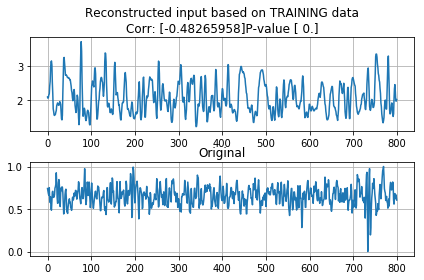

In [23]:
reconstruct_training_sample = True
chan = 13
samp = 180

from scipy.stats import pearsonr
# now let's see how the model performs:
r_accumulator = []

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
    orig = x_train[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_train.shape[0]):
        reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
        orig = x_train[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Training sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))
else:
    reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
    orig = x_test[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TESTING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_test.shape[0]):
        reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
        orig = x_test[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Test sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.set_title(title)
ax.grid()
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
plt.tight_layout()
ax.set_title("Original")
ax.grid()

Test sample 0 : Correlation  [-0.41114596]  P-value:  [  5.57751866e-34]
Test sample 1 : Correlation  [-0.39765444]  P-value:  [  1.05055740e-31]
Test sample 2 : Correlation  [-0.41413012]  P-value:  [  1.69434987e-34]
Test sample 3 : Correlation  [-0.59005207]  P-value:  [ 0.]
Test sample 4 : Correlation  [-0.55271184]  P-value:  [ 0.]
Test sample 5 : Correlation  [-0.52378923]  P-value:  [ 0.]
Test sample 6 : Correlation  [-0.506172]  P-value:  [ 0.]
Test sample 7 : Correlation  [-0.48325408]  P-value:  [ 0.]
Test sample 8 : Correlation  [-0.49011937]  P-value:  [ 0.]
Test sample 9 : Correlation  [-0.48578355]  P-value:  [ 0.]
Test sample 10 : Correlation  [-0.47526699]  P-value:  [ 0.]
Test sample 11 : Correlation  [-0.53791755]  P-value:  [ 0.]
Test sample 12 : Correlation  [-0.4943741]  P-value:  [ 0.]
Test sample 13 : Correlation  [-0.45385814]  P-value:  [  6.65196381e-42]
Test sample 14 : Correlation  [-0.51010078]  P-value:  [ 0.]
Test sample 15 : Correlation  [-0.46715072]  P

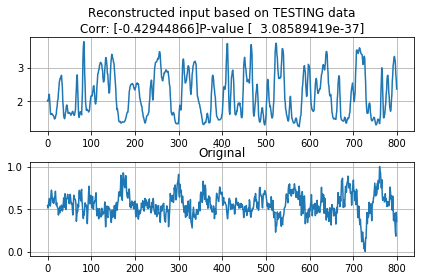

In [26]:
reconstruct_training_sample = False
chan = 13
samp = 36

from scipy.stats import pearsonr
# now let's see how the model performs:
r_accumulator = []

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
    orig = x_train[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_train.shape[0]):
        reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
        orig = x_train[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Training sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))
else:
    reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
    orig = x_test[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TESTING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_test.shape[0]):
        reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
        orig = x_test[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Test sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.set_title(title)
ax.grid()
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
plt.tight_layout()
ax.set_title("Original")
ax.grid()